Imports

In [19]:
import numpy as np
import tensorflow as tf
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
import pylab as plt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

Set seed for reproducibility

In [20]:
"""
Set seed for reproducibility

Inputs:
    None
Outputs:
    None
"""

np.random.seed(123)  # Setting seed for NumPy
tf.random.set_seed(123)  # Setting seed for TensorFlow

Preprocess data and Split the data into train and test sets

In [21]:
"""
Preprocessing

Inputs:
    base_dir: The directory where the data is located.
    categories: The different categories in the dataset.
Outputs:
    images: The processed images.
    labels: The labels for the images.
"""

base_dir = "./dataset_18/"
categories = ["covid", "normal"]
img_height = 256
img_width = 256
img_paths=[]
def load_images(base_dir, categories):
    images = []
    labels = []

    for category in categories:
        path = os.path.join(base_dir, category)
        class_num = categories.index(category)  # Assign an integer label to each category

        # Iterate over each image in the category directory
        for img in os.listdir(path):
            try:
                # Load the image from the disk
                img_array = cv2.imread(os.path.join(path, img))
                
                # Resize the image
                img_resized = cv2.resize(img_array, (img_height, img_width))

                # Normalize pixel values
                img_resized = img_resized / 255.0

                images.append(img_resized)
                labels.append(class_num)
            except Exception as e:
                print(f"Error: {e}")

    return np.array(images), np.array(labels)

images, labels = load_images(base_dir, categories)
# Encoding labels: 'COVID' to 0 and 'Normal' to 1
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=123)

Create EarlyStopping callback for tensorflow training.
This allows the training to be stopped when there is no improvement.

In [22]:
"""
Create EarlyStopping callback for tensorflow training. This allows the training to be stopped when there is no improvement.

Inputs:
    None
Outputs:
    early_stopping: A callback that can be used during model training.
"""
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

Define autoencoder model

In [23]:
"""
Define autoencoder model

Inputs:
    None
Outputs:
    autoencoder: The autoencoder model.
"""
# Define the input shape
input_img = Input(shape=(img_height, img_width, 3))

# Encoding part
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoding part
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Create the autoencoder model
autoencoder = Model(input_img, decoded)

# Compile the autoencoder model with Adam optimizer and binary cross-entropy loss
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [24]:
autoencoder.fit(X_train, X_train, 
                epochs=50, batch_size=32,
                validation_data=(X_val, X_val), 
                callbacks=[early_stopping])

Epoch 1/50
11/11 [==============================] - 3s 221ms/step - loss: 0.6711 - val_loss: 0.6597
Epoch 2/50
11/11 [==============================] - 2s 203ms/step - loss: 0.6236 - val_loss: 0.5934
Epoch 3/50
11/11 [==============================] - 2s 204ms/step - loss: 0.5785 - val_loss: 0.5614
Epoch 4/50
11/11 [==============================] - 2s 199ms/step - loss: 0.5626 - val_loss: 0.5534
Epoch 5/50
11/11 [==============================] - 2s 155ms/step - loss: 0.5567 - val_loss: 0.5508
Epoch 6/50
11/11 [==============================] - 2s 160ms/step - loss: 0.5541 - val_loss: 0.5486
Epoch 7/50
11/11 [==============================] - 2s 147ms/step - loss: 0.5527 - val_loss: 0.5476
Epoch 8/50
11/11 [==============================] - 2s 161ms/step - loss: 0.5518 - val_loss: 0.5469
Epoch 9/50
11/11 [==============================] - 2s 150ms/step - loss: 0.5512 - val_loss: 0.5468
Epoch 10/50
11/11 [==============================] - 2s 164ms/step - loss: 0.5508 - val_loss: 0.5462

Encode images using the encoder model

In [25]:
"""
Encode images using the encoder model

Inputs:
    images: The images to be encoded.
Outputs:
    encoded_images: The encoded images.
"""
# encode images using the encoder model
max_pooling_layers = [layer.name for layer in autoencoder.layers if 'max_pooling' in layer.name]
latest_max_pooling_layer = max_pooling_layers[-1]

# Create the encoder model with the latest max pooling layer as the output
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(latest_max_pooling_layer).output)
encoded_images = encoder.predict(images)
encoder.save('encoder_model')

14/14 [==============================] - 0s 12ms/step


INFO:tensorflow:Assets written to: encoder_model\assets


INFO:tensorflow:Assets written to: encoder_model\assets


Split the encoded images into training and testing sets

In [26]:
"""
Split the encoded images into training and testing sets

Inputs:
    encoded_images: The encoded images.
    labels: The labels for the images.
Outputs:
    x_train_encoded: The training data.
    x_test_encoded: The testing data.
    y_train_encoded: The labels for the training data.
    y_test_encoded: The labels for the testing data.
"""
# Split the encoded images into training and testing sets
x_train_encoded, x_test_encoded, y_train_encoded, y_test_encoded = train_test_split(
    encoded_images, 
    labels,
    test_size=0.2, 
    random_state= 123,
    stratify = labels)

Define CNN model

In [27]:
"""
Define CNN model

Inputs:
    None
Outputs:
    CNN_model: The CNN model.
"""
# Define the model architecture
CNN_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=encoded_images.shape[1:]),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(), # Flatten the output from the convolutional part of the CNN
    Dense(64, activation='relu'),
    Dense(2, activation='softmax') # Output layer, 'softmax' for binary classification
])

# Compile the model
CNN_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Print a summary of the model
# CNN_model.summary()


In [28]:
# fit CNN model
epochs = 50 # You can change this value

history = CNN_model.fit(x_train_encoded, 
                        y_train_encoded, 
                        epochs=epochs, 
                        validation_data=(x_test_encoded, y_test_encoded),
                        callbacks=[early_stopping])

Epoch 1/50
11/11 [==============================] - 1s 38ms/step - loss: 0.6797 - accuracy: 0.6047 - val_loss: 0.6337 - val_accuracy: 0.5930
Epoch 2/50
11/11 [==============================] - 0s 19ms/step - loss: 0.6029 - accuracy: 0.6424 - val_loss: 0.5409 - val_accuracy: 0.6628
Epoch 3/50
11/11 [==============================] - 0s 20ms/step - loss: 0.5316 - accuracy: 0.6977 - val_loss: 0.4967 - val_accuracy: 0.7442
Epoch 4/50
11/11 [==============================] - 0s 19ms/step - loss: 0.4697 - accuracy: 0.7471 - val_loss: 0.5369 - val_accuracy: 0.7093
Epoch 5/50
11/11 [==============================] - 0s 20ms/step - loss: 0.4471 - accuracy: 0.7878 - val_loss: 0.5014 - val_accuracy: 0.7442
Epoch 6/50
11/11 [==============================] - 0s 19ms/step - loss: 0.4525 - accuracy: 0.7762 - val_loss: 0.4391 - val_accuracy: 0.8023
Epoch 7/50
11/11 [==============================] - 0s 18ms/step - loss: 0.3593 - accuracy: 0.8663 - val_loss: 0.3959 - val_accuracy: 0.7907
Epoch 8/50
11

In [29]:
CNN_model_fine_tune_epoch = early_stopping.stopped_epoch + 1 - 5 # -5 because of patience
total_epoch = early_stopping.stopped_epoch + 1
print("current best model epoch: ", CNN_model_fine_tune_epoch)
print("total epoch trained: ", total_epoch)

current best model epoch:  15
total epoch trained:  20


Validation Loss: 0.27992746233940125
Training Loss: 0.10438525676727295
Accuracy: 0.9651162624359131
Validation Accuracy: 0.8837209343910217


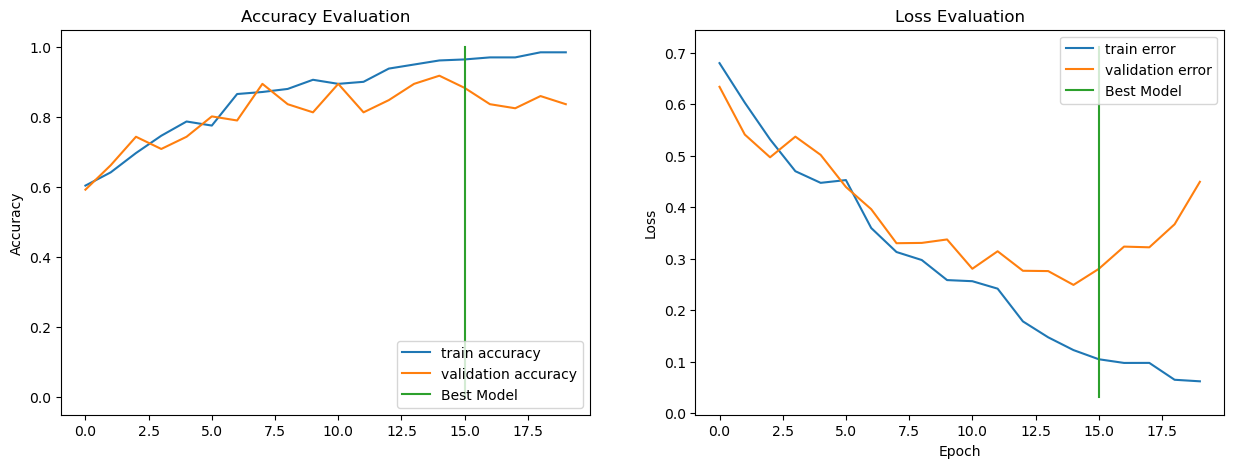

In [30]:
def plot_history(history, best_epoch):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="validation accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_title("Accuracy Evaluation")
    axs[0].plot([best_epoch, best_epoch],
            plt.ylim(), label='Best Model')
    axs[0].legend(loc="lower right")

    # create error subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="validation error")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].set_title("Loss Evaluation")
    axs[1].plot([best_epoch, best_epoch],
            plt.ylim(), label='Best Model')
    axs[1].legend(loc="upper right")
    print("Validation Loss:", history.history['val_loss'][best_epoch])
    print("Training Loss:", history.history['loss'][best_epoch])
    print("Accuracy:", history.history['accuracy'][best_epoch])
    print("Validation Accuracy:", history.history['val_accuracy'][best_epoch])

    plt.show()

plot_history(history, CNN_model_fine_tune_epoch)

In [31]:
def report(x_test_encoded, y_test_encoded, model):
    # Perform predictions on the test set
    y_pred = model.predict(x_test_encoded)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test_encoded, axis=1) 

    # Print classification report
    print(classification_report(y_test_classes, y_pred_classes, target_names=categories))

report(x_test_encoded, y_test_encoded, CNN_model)


def auc_roc(x_test_encoded, y_test_encoded, model):
    # Use the model to predict the probabilities for the test set
    y_prob = model.predict(x_test_encoded)

    # Compute the AUC-ROC
    roc_auc = roc_auc_score(y_test_encoded, y_prob)

    print('AUC-ROC:', roc_auc)

auc_roc(x_test_encoded, y_test_encoded, CNN_model)


3/3 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

       covid       0.89      0.92      0.90        36
      normal       0.94      0.92      0.93        50

    accuracy                           0.92        86
   macro avg       0.92      0.92      0.92        86
weighted avg       0.92      0.92      0.92        86

3/3 [==============================] - 0s 5ms/step
AUC-ROC: 0.9566666666666668


Number of layers in the model:  7
Epoch 1/50
11/11 [==============================] - 1s 29ms/step - loss: 0.1047 - accuracy: 0.9709 - val_loss: 0.2488 - val_accuracy: 0.9186
Epoch 2/50
11/11 [==============================] - 0s 13ms/step - loss: 0.1047 - accuracy: 0.9709 - val_loss: 0.2488 - val_accuracy: 0.9186
Epoch 3/50
11/11 [==============================] - 0s 18ms/step - loss: 0.1047 - accuracy: 0.9709 - val_loss: 0.2488 - val_accuracy: 0.9186
Epoch 4/50
11/11 [==============================] - 0s 15ms/step - loss: 0.1047 - accuracy: 0.9709 - val_loss: 0.2488 - val_accuracy: 0.9186
Epoch 5/50
11/11 [==============================] - 0s 14ms/step - loss: 0.1047 - accuracy: 0.9709 - val_loss: 0.2488 - val_accuracy: 0.9186
Epoch 6/50
11/11 [==============================] - 0s 14ms/step - loss: 0.1047 - accuracy: 0.9709 - val_loss: 0.2488 - val_accuracy: 0.9186
Epoch 6: early stopping
Best validation loss obtained:  0.24881500005722046
Best epoch:  15


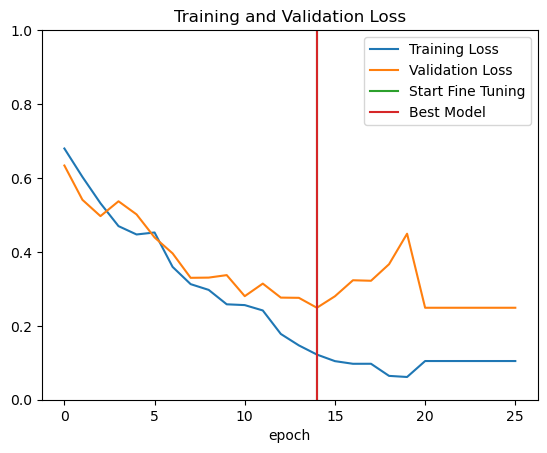

In [32]:
"""
Fine-tuning the CNN model

Inputs:
    CNN_model: The CNN model to be fine-tuned.
    x_train_encoded: The training data.
    y_train_encoded: The labels for the training data.
    history: The history object of CNN_model.
    fine_tune_at: The layer at which the fine-tuning will start.
Outputs:
    CNN_model: The fine-tuned model.
    best_epoch: The epoch that resulted in the best validation loss.
    history_fine: The history object that contains information about the fine-tuning process.
"""
def tuning(CNN_model, x_train_encoded, y_train_encoded, history, fine_tune_at):
    # Unfreeze all layers in the model
    CNN_model.trainable = True

    # Let's take a look to see how many layers are in the model
    print("Number of layers in the model: ", len(CNN_model.layers))

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in CNN_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Compile the model with a lower learning rate for fine-tuning
    CNN_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), 
                loss='binary_crossentropy',
                metrics=['accuracy'])

    # Train the model again (this time fine-tuning some layers)
    history_fine = CNN_model.fit(x_train_encoded, 
                        y_train_encoded, 
                        epochs=epochs, 
                        validation_data=(x_test_encoded, y_test_encoded),
                    callbacks=[early_stopping])
    
    loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']

    
    best_val_loss = min(history.history['val_loss'])
    print('Best validation loss obtained: ', best_val_loss)

    best_epoch = history.history['val_loss'].index(best_val_loss)
    print('Best epoch: ', best_epoch + 1)


    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylim([0, 1.0])
    plt.plot([fine_tune_at - 1,fine_tune_at -1],
            plt.ylim(), label='Start Fine Tuning')
    plt.plot([best_epoch, best_epoch],
            plt.ylim(), label='Best Model')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

    return CNN_model, best_epoch, history_fine
        
    
fine_tune_model, best_epoch, history_fine = tuning(CNN_model, x_train_encoded, y_train_encoded, history, CNN_model_fine_tune_epoch)

Validation Loss: 0.24881500005722046
Training Loss: 0.12218059599399567
Accuracy: 0.9622092843055725
Validation Accuracy: 0.9186046719551086


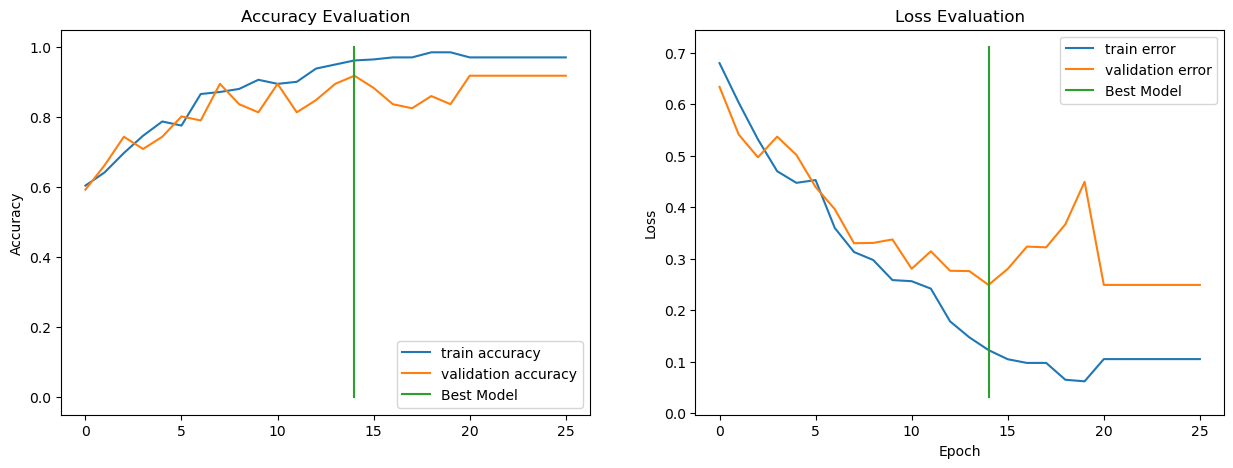

In [33]:
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# create accuracy subplot
axs[0].plot(acc, label="train accuracy")
axs[0].plot(val_acc, label="validation accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Accuracy Evaluation")
axs[0].plot([best_epoch, best_epoch],
        plt.ylim(), label='Best Model')
axs[0].legend(loc="lower right")

# create error subplot
axs[1].plot(loss, label="train error")
axs[1].plot(val_loss, label="validation error")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].set_title("Loss Evaluation")
axs[1].plot([best_epoch, best_epoch],
        plt.ylim(), label='Best Model')
axs[1].legend(loc="upper right")
print("Validation Loss:", val_loss[best_epoch])
print("Training Loss:", loss[best_epoch])
print("Accuracy:", acc[best_epoch])
print("Validation Accuracy:", val_acc[best_epoch])

plt.show()

In [34]:
report(x_test_encoded, y_test_encoded, fine_tune_model)

3/3 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

       covid       0.89      0.92      0.90        36
      normal       0.94      0.92      0.93        50

    accuracy                           0.92        86
   macro avg       0.92      0.92      0.92        86
weighted avg       0.92      0.92      0.92        86



In [35]:
auc_roc(x_test_encoded, y_test_encoded, CNN_model)

3/3 [==============================] - 0s 6ms/step
AUC-ROC: 0.9566666666666668


In [36]:
"""
Saving the CNN model

Inputs:
    fine_tune_model: The model to be saved.
Outputs:
    None
"""
fine_tune_model.save('cnn_model')

INFO:tensorflow:Assets written to: cnn_model\assets


INFO:tensorflow:Assets written to: cnn_model\assets
